# Tornado Prediction 

In this project, we are doing 3-category ("torn":0, "wind":1, "hail":2) classification based on some tabular data. We will use interpretable Logistic Regression as the baseline method and compare its performance with 3 advanced models on MRMS Dataset:
1. Random Forest;
2. LightGBM;
3. XGBoost;

MRMS Dataset contains weather data at different: 1.time, 2.location, 3.varaibles related to weather (e.g. temperture, humidity, etc), 4.SHSR data. 5. weather type (tornado, wind, hail, etc).

Note - In this whole project, we will consistently use widely-used python libraries, like numpy, pandas and sklearn. 

In [2]:
# Load necessary libraries. 
import os 
import random 
import shap 

# import our models 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier 

## 1. Split Data and Data Preprocessing

For now, we can only use .nc files' SHSR data to do classification or only use tabular data collected by us. 

csvdata_combine_and_split(csv_path, cls_names, vars, ratio=[4,1,1], comb_file="comb") 

funcs 
1. Randomly split the data into train/val/test sets with the ratio 4:1:1;
2. Only keep given variables for later training and prediction;
3. In original data, 'preciptype' is nan or ['rain'], replace them with 0 and 1;
4. [for now] Replace all missing values with 0;
5. Save the combined file as "Combine_with_Temp/comb.csv".

Select proper varaibles that will be used for later training and prediction by defining a list vars;
We are building diagnostic model at one location and time stamp (ignore columns describing time and location);
In original csv file - all variables: <class 'numpy.float64'> dtype;  'preciptype': <class 'float'> / <class 'str'> dtype;

[torn] category, 1359 items; [wind] category, 15525 items; [hail] category, 6261 items;

In [2]:
import numpy as np 
import pandas as pd 
from netCDF4 import Dataset

nc_path = "Archive/data/"
csv_path = "Archive/"
cls_names = { "torn":0, "wind":1, "hail":2 }

nc_file = nc=Dataset( nc_path + "hail/0.nc" ) 
shsr = nc_file.variables["SHSR"][:].data
print( type(shsr), shsr.shape )      # shsr data is <class 'numpy.ndarray'> and has a shape as (l, m, n). 
print( np.mean(shsr), np.max(shsr), np.min(shsr), np.var(shsr), np.count_nonzero(shsr) )

# Create new features based on SHSR data (Note - there might be some missing values).
def get_shsr_stats( nc_path, n ):
    stats = { "mean":[], "max":[], "min":[], "var":[], "nonzeros":[] }
    for i in range(n):
        if os.path.exists( nc_path + "/{}.nc".format(i) ):
            nc_file = nc=Dataset( nc_path + "/{}.nc".format(i) )  
            shsr = nc_file.variables["SHSR"][:].data
            tmp = [ np.mean(shsr), np.max(shsr), np.min(shsr), np.var(shsr), np.count_nonzero(shsr) ] 
        else:
            tmp = [0,0,0,0,0] 
        stats["mean"].append( tmp[0] )
        stats["max"].append( tmp[1] )
        stats["min"].append( tmp[2] )
        stats["var"].append( tmp[3] )
        stats["nonzeros"].append( tmp[4] ) 
    return stats 

for cls in cls_names:
    frame_extra = pd.read_csv( csv_path+"2021_{}_UTC_combine_temperature.csv".format(cls) ) 
    frame_index = pd.read_csv( csv_path+"2021_{}.csv".format(cls) ) 
    print( f"The lengths of {cls}'s extra variables and indexes are {len(frame_extra)} and {len(frame_index)}" )

<class 'numpy.ndarray'> (20, 40, 40)
22.11169 60.3 0.0 170.40974 26852
The lengths of torn's extra variables and indexes are 1364 and 1364
The lengths of wind's extra variables and indexes are 15525 and 15525
The lengths of hail's extra variables and indexes are 6261 and 6261


In [3]:
nc_path = "Archive/data/"
csv_path = "Archive/" 
cls_names = { "torn":0, "wind":1, "hail":2 }  # weather type and their assigned labels 
vars = [ 'temp', 'humidity', 'dew', 'precip', 'preciptype', 'windspeed', 'winddir', 'pressure', 'cloudcover', 'visibility']
stat_vars = [ "mean", "max", "min", "var", "nonzeros" ]

def csvdata_combine_and_split(csv_path, cls_names, vars, ratio=[4,1,1], save_file="comb", if_balanced=True): 
    # the way to split pandas data 
    comb = []
    for cls in cls_names:
        frame = pd.read_csv( csv_path+"2021_{}_UTC_combine_temperature.csv".format(cls) )
        frame = frame.fillna(0)
        if if_balanced:
            n = min( len(frame), 3000 )
        else:
            n = len(frame)
        curr = frame[ vars ][:n]
        print( f"In [{cls}] category, there are {n} items in total" )
        stats = get_shsr_stats( nc_path+"/"+cls+"/", n )
        for stat in stats:
            curr[stat] = stats[stat] 
        sets = [ "val" ]*int(n/sum(ratio)) + ["test"]*int(n/sum(ratio)) + ["train"]*(n-2*int(n/ sum(ratio) )) 
        random.shuffle(sets) 
        cls_list = [ cls_names[cls] ] * n 
        curr['label'] = cls_list    
        curr['set'] = sets 
        preciptypes = [ 0 ] * n
        for i in range(n):
            if curr['preciptype'][i] == "['rain']":
                preciptypes[i] = 1
        curr['preciptype'] = preciptypes
        comb.append(curr)
    comb = pd.concat( comb, axis=0 ) 
    comb.to_csv( csv_path + save_file + ".csv" ) 

# uncomment to create split data randomly and save as a new comb.csv
# csvdata_combine_and_split(csv_path, cls_names, vars, ratio=[4,1,1], save_file="comb_balanced")
vars += stat_vars

#### Functions to Read Data 
provide functions to read our combined data as train/val/test sets, data/labels.

In [4]:
# we should balance train data among different categories ... 
def read_data( csv, vars, set='train' ):
    dframe = pd.read_csv( csv )
    x = dframe[ dframe['set']==set ][vars]
    y = dframe[ dframe['set']==set ]['label'].values        
    return x,y 

In [5]:
csv_file = "comb.csv"
train_x, train_y = read_data( csv_path + "/" + csv_file, vars, set="train" )
print( train_x.shape, train_y.shape )
val_x, val_y = read_data( csv_path + "/" + csv_file, vars, set="val" )
test_x, test_y = read_data( csv_path + "/" + csv_file, vars, set="test" )

(15436, 15) (15436,)


## 2. Building Machine Learning Models for 3-Category Prediction 

Models
1. [Baseline] Logistic Regression;
2. Random Forest;
3. LightGBM;
4. XGBoost;

Evaluation:
1. Accuracy, Precision, Recall, F1 Score; 
2. Accuracy Curve Plot during training;
3. Confusion Matrix;


In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay 

def evaluate( model, train_x, train_y, test_x, test_y ):
    """ uses the model to calculate a set of scores """
    # accuracy_score
    print('Test Accuracy     :',model.score(test_x, test_y))
    print('Training Accuracy    :',model.score(train_x,train_y))
    pred_y = model.predict(test_x)
    precision, recall, f1 = precision_score( test_y, pred_y, average='micro' ), recall_score( test_y, pred_y, average='micro' ), f1_score( test_y, pred_y, average='micro')
    print('Testing precision :', precision )
    print('Testing recall    :', recall )
    print('F1 score          :', f1 )
    conf_mat = confusion_matrix( test_y, pred_y )
    display = ConfusionMatrixDisplay(conf_mat)
    display.plot()
    # ROC AUC
    probs=model.predict_proba(test_x)
    print('ROC AUC           : %f' % roc_auc_score(test_y, probs, average="weighted", multi_class='ovo'))

#### 1. Logistic Regression 

Logistic Regression is ...

============================= Logistic Regression =============================
Test Accuracy     : 0.7184340160746694
Training Accuracy    : 0.7334153925887535
Testing precision : 0.7184340160746694
Testing recall    : 0.7184340160746694
F1 score          : 0.7184340160746694
ROC AUC           : 0.753077


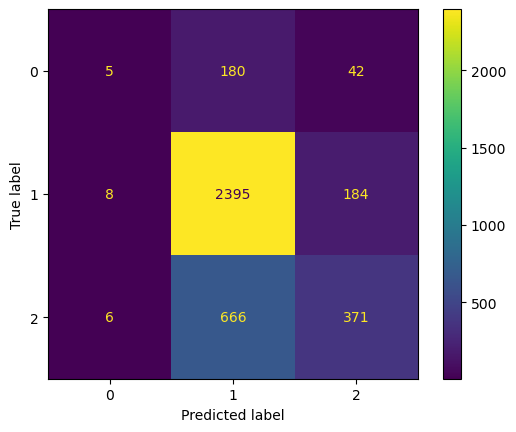

In [7]:
print('============================= Logistic Regression =============================')
lg = LogisticRegression(C=0.1,penalty='l2',max_iter=5000, 
                           solver="lbfgs",multi_class='multinomial', 
                           random_state=0)

# print( np.count( np.isnan(train_x), True), np.count( np.isnan(train_y), True) )

lg.fit(train_x,train_y)
evaluate(lg, train_x, train_y, test_x, test_y) 

#### 2. Random Forest 

Random Forest is ...

============================= Random Forest =============================
Test Accuracy     : 0.7184340160746694
Training Accuracy    : 0.7334153925887535
Testing precision : 0.7184340160746694
Testing recall    : 0.7184340160746694
F1 score          : 0.7184340160746694
ROC AUC           : 0.753077


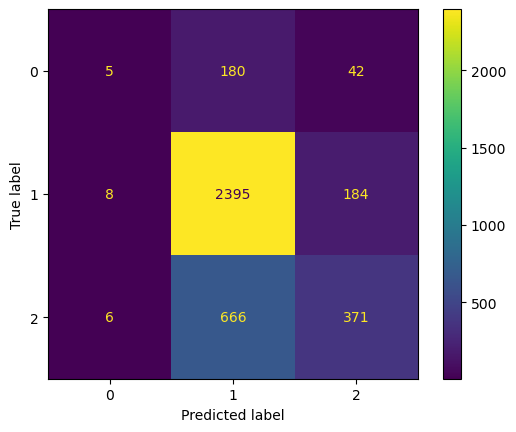

In [8]:
print('============================= Random Forest =============================')
params = {
    "criterion":'gini', "max_depth":5, "min_samples_split":5, "min_samples_leaf":3, "min_weight_fraction_leaf":0.5, "max_features":'sqrt', 
    "max_leaf_nodes":5, "min_impurity_decrease":0.0, "bootstrap":True, "oob_score":False, "n_jobs":None, "random_state":None, 
    "verbose":0, "warm_start":False, "class_weight":None, "ccp_alpha":0.0, "max_samples":None
}
rfc = RandomForestClassifier( **params )
rfc.fit(train_x, train_y)
evaluate(lg, train_x, train_y, test_x, test_y) 

#### 3. LightGBM
LightGBM is ...

============================= LightGBM =============================
Test Accuracy     : 0.8130671506352087
Training Accuracy    : 0.9069707178025396
Testing precision : 0.8130671506352087
Testing recall    : 0.8130671506352087
F1 score          : 0.8130671506352088
ROC AUC           : 0.885597


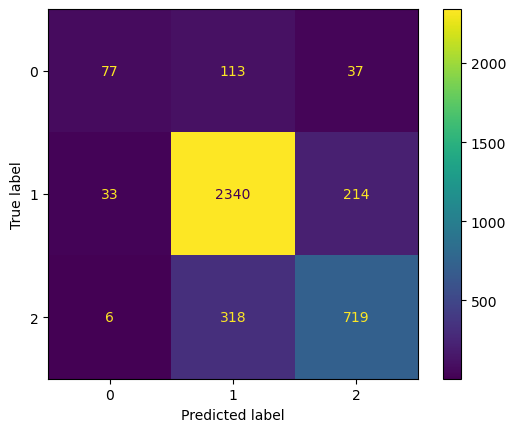

In [9]:
print('============================= LightGBM =============================')
params = {
            'objective':"multiclass",
            'metric' : 'multi_logloss',
            'num_class': 3,
            'verbose' : -1,    # what does verbose mean???
            'boosting_type' : 'gbdt',
            'colsample_bytree' : 0.3,
            'num_leaves' : 10,
            'max_depth' : 3,
            'n_estimators' : 3000,
            'min_child_samples': 10, 
            'min_child_weight': 0.5,
            'reg_alpha': 0.1,
            'reg_lambda': 10,
            'subsample': 0.5,
            'num_threads' : 4,
            'learning_rate':0.06
}

lgb = LGBMClassifier(**params)
lgb.fit(train_x, train_y)
evaluate( lgb, train_x, train_y, test_x, test_y )

#### 4. XGBoost 
XGBoost is ... 

============================= XGBoost =============================
Test Accuracy     : 0.8032149338864403
Training Accuracy    : 0.8776885203420576
Testing precision : 0.8032149338864403
Testing recall    : 0.8032149338864403
F1 score          : 0.8032149338864403
ROC AUC           : 0.878694


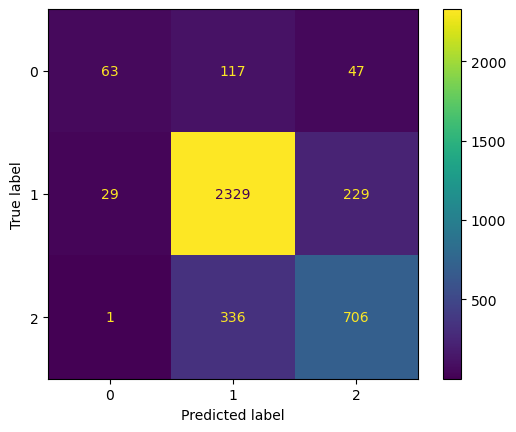

In [10]:
print('============================= XGBoost =============================')

param = {'base_score':0.5,'booster':'gbtree','objective':'multi:softmax',
        'max_delta_step':2,'n_jobs':4,'random_state':0, 'max_depth':3,
         'min_child_weight':3,'n_estimators':3000,'subsample':1.0,'colsample_bytree':0.3,
         'reg_lambda':10,'reg_alpha':0.1,'learning_rate':0.05,'gamma':0.3}    

xgb = XGBClassifier(**param)
xgb.fit(train_x, train_y) 
evaluate( xgb, train_x, train_y, test_x, test_y )

## 3. Shap - Black-Box Machine Learning Model Output Analysis 

Here, we use shap library to help us identify the importance of each feature to the model outputs. 

#### Shap Feature Importance for LightGBM Model

============================== SHAP ===============================


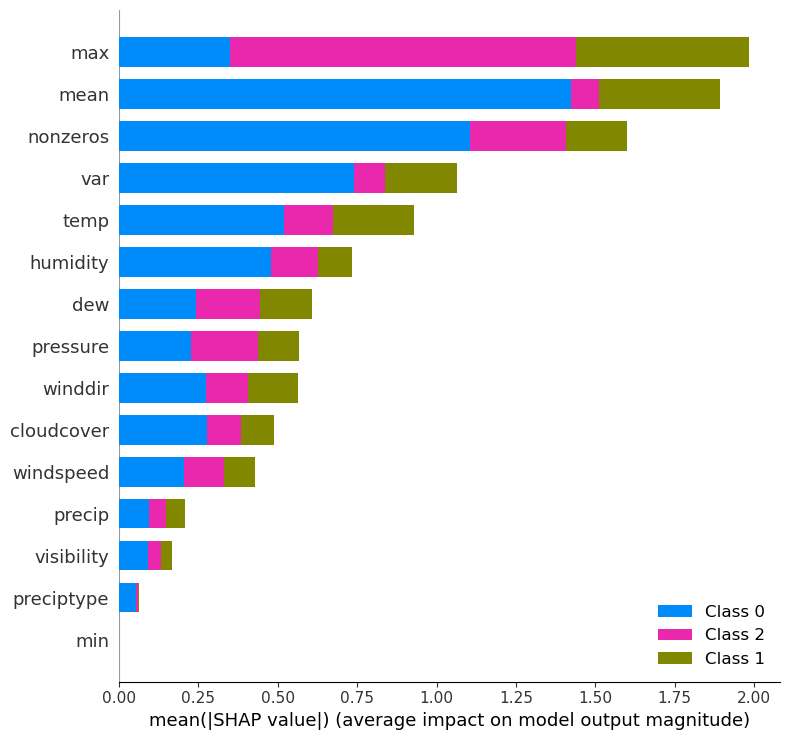

In [36]:
print('============================== SHAP ===============================')
explainer = shap.TreeExplainer(lgb)   # define the explainer
test_shap = explainer.shap_values(test_x)
shap.summary_plot(test_shap, test_x, plot_type="bar")

#### Shap Feature Importance for XGBOOST Model

============================== SHAP ===============================


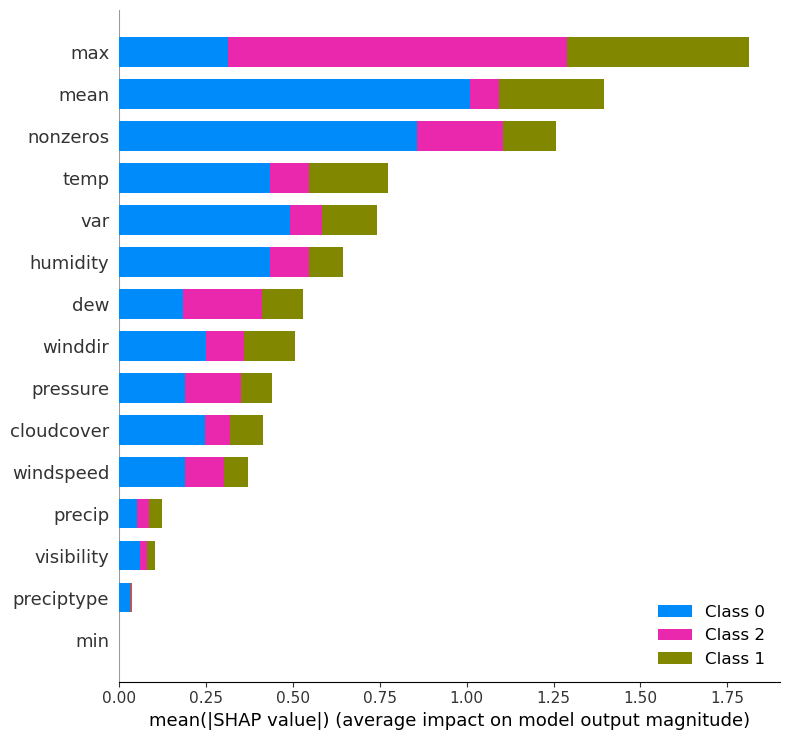

In [37]:
print('============================== SHAP ===============================')
explainer = shap.TreeExplainer(xgb)   # define the explainer
test_shap = explainer.shap_values(test_x)
shap.summary_plot(test_shap, test_x, plot_type="bar")